In [1]:
#!/usr/env python3
'''This script pulls in inventory data, 
   builds and tests several predictive models and predicts backorder using the best model'''
   
__author__ = 'Sam M. Mfalila'
__email__ = 'sam.mfalila@gmail.com'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
import sklearn.preprocessing
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from helpers import make_confusion_matrix
from sklearn.metrics import confusion_matrix

from build_library.utils import FeatureSelector, DropMissing, CategoricalFeatsAdded,\
RemoveNegativeValues, CategoricalImputerTransformer, SimpleImputerTransformer, \
CapOutliers, DelUnusedCols, StandardScalerTransformer

import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,6)

#dispaly all digits
pd.set_option('float_format', '{:f}'.format)

In [5]:
#define data file path and target variable
file = 'derived_data/balanced.csv'
target = 'went_on_backorder_Yes'
seed = 777



validation_features = pd.read_csv('derived_data/validation_feats_balanced.csv')
validation_target = pd.read_csv('derived_data/validation_target_balanced.csv')

column_names = ['neg_inv_bal','low_inventory','low_intransit','high_forcast',\
                'national_inv','lead_time','in_transit_qty','forecast_3_month',]



class Data():
    '''Loads data, samples training data if specified, assigns features_df and target_df
    '''   
    def __init__(self, file, target, sample=False, n_samples=None, frac=None):
        self.file = file
        self. sample = sample
        self.n_sample = n_sample
        self.target = target
        self.frac = frac
    
    def get_data(file, sample=False, n_samples=None, frac=None):
        '''Load train data with option to sample'''
        data = pd.read_csv(file)
        if sample:
            '''Sample train data due to resource limitation'''
            #data = data.sample(n_samples, random_state=123)
            data = data.groupby(target).apply(lambda x: x.sample(frac=frac))
            data = data.reset_index(drop=True)
        else:
            data = data
        print(data.shape, 'data loaded\n')
        return data
         
    def get_features():
        '''Assign features dataframe'''
        features_df = data
        print(features_df.shape, 'features assigned\n')
        return features_df
        
    def get_target():
        '''Assign target'''
        target_df = data[target].values
        print(target_df.shape, '...target rows loaded\n')
        return target_df
   

            
class Models(object):
    '''This class holds all modeling objects
       Note: Instantiate any additional models to test as class variables below    
    '''
    estimators = {}
    fitted_grid = {}
    param_grids = {}
    best_models = {}
    best_score = None 
    best_model = []
    best_params = {}
    best_model_params = []
    best_model_list = []
    best_estimator = {}
    lr = LogisticRegression(random_state=seed)
    sv = SVC(random_state=seed)
    ld = LinearDiscriminantAnalysis()
    sg = SGDClassifier(random_state=seed)
    rf = RandomForestClassifier(random_state=seed)
    gb = GradientBoostingClassifier(random_state = seed)
    nb = GaussianNB()
    results_dict={}
    full_grid={}
    cv_results_dict ={}
    best_params_dict={}
    backorder_clf_param = {}
    scikit_version = None
    saved_model = None
    full_pipeline = None
    
    
    def __init__(self, master, logreg, svc,lda, sgd, randforest, gradboost, 
                 gnb, n_iter, scoring, n_jobs, train_features):
        self.master = master
        self.logreg = logreg
        self.svc = svc
        self.lda = lda
        self.sgd = sgd
        self.randforest= randforest
        self.gradboost = gradboost
        self.gnb = gnb
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.train_features = train_features  
        
    def hyperparameters(logreg=True, svc=True, lda=True,
                        sgd=True, randforest=True, gradboost=True, gnb=True):
        '''Define model hyperparameters for tuning
           Add aditional models hyperparameters for tuning here as needed        
        '''
        if logreg:
            '''set lr hyperparameters for tuning'''
            #select hyperparameters for logreg
            lr_penalty_options = ['l1', 'l2', 'elasticnet']
            lr_C_options = [0.001,0.01,0.1,1,10,100,1000]
            random_state_options = [7]
            lr_solver_options = ['newton-cg','liblinear','lbfgs', 'sag', 'saga']
            lr_C_options = [0.001,0.01,0.1,1,10,100,1000]
            
            #set param grid for lr
            lr_param_grid = dict(penalty = lr_penalty_options,\
                                 C = lr_C_options, \
                                 random_state = random_state_options, \
                                 solver = lr_solver_options
                                 )
            
            #add param grid to param_grids
            Models.param_grids['lr'] = lr_param_grid

        if svc:
            '''set svc hyperparameters for tuning'''
            #select hyperparameters for svc
            sv_kernel_options = ['linear','rbf', 'poly', 'sigmoid']
            sv_C_options = [0.001,0.01,0.1,1,10,100]
            sv_gamma_options = [1, 0.1, 0.01, 0.001, 0.0001]
            
            #set param grid for svc
            sv_param_grid = dict(kernel = sv_kernel_options,\
                                 C = sv_C_options,\
                                 gamma = sv_gamma_options)
            
            #add param grid to param_grids
            Models.param_grids['sv'] = sv_param_grid
            
        if lda:
            '''set lda hyperparameters'''
            ld_solver_options = ['svd', 'lsqr', 'eigen']
            
            #set hyperparameter grid for lda
            ld_param_grid = dict(solver = ld_solver_options)
            
            #add param grid to param_grids
            Models.param_grids['ld'] = ld_param_grid
            
        if sgd:
            '''set sgd hyperparameters'''
            sg_max_iter_options = ['1000', '100000']
            sg_tol_options = [1e-3]
            
            #set hyperparameter grid for sgd
            sg_param_grid = dict(max_iter = sg_max_iter_options,\
                                 tol = sg_tol_options)
            
            #add param grid to param_grids
            Models.param_grids['sg'] = sg_param_grid
                                    
        if randforest:
            '''set rf hyperparameters for tuning'''
            #select hyperparameters for rf
            rf_n_estimators_options =[10,75,100,150,200,1000]
            rf_max_features_options = ['auto','sqrt', 'log2',  0.33]
            
            #set param grid for rf
            rf_param_grid = dict(n_estimators = rf_n_estimators_options,\
                                 max_features = rf_max_features_options)
            
            #add param grid to param_grids
            Models.param_grids['rf'] = rf_param_grid
        
        if gradboost:
            '''set gb hyperparameters for tuning'''
            #select hyperparameters for gb
            gb_n_estimators_options = [10, 100, 200, 1000]
            gb_learning_rate_options = [0.001, 0.01, 0.05, 0.1, 0.2]
            gb_max_depth_options = [1, 3, 5, 7, 9]
            gb_subsample_options = [0.5,0.7,1.0]
            
            #set param grid for gb
            gb_param_grid = dict(learning_rate = gb_learning_rate_options,\
                                 n_estimators = gb_n_estimators_options,\
                                 subsample = gb_subsample_options,\
                                 max_depth = gb_max_depth_options)
            
            #add param grid to param_grids
            Models.param_grids['gb'] = gb_param_grid
            
        if gnb:
            '''set hyperparameters for gausian naive bayes'''
            #select hyperparameters for gnb
            nb_priors_options = [None]
            nb_var_smoothing_options = [1e-09]
            
            #set param grid for gnb
            nb_param_grid = dict(priors = nb_priors_options,\
                                 var_smoothing = nb_var_smoothing_options)
            
            #add param_grid to param_grids
            Models.param_grids['nb'] = nb_param_grid
               
        print('Hyperparameter grid is set\n')
                
    def setting_gridsearch(logreg=False, svc=False, lda=False, sgd=False,\
                           randforest=False, gradboost=False, gnb=False):
        '''Selects estimators to tune and holds them in a dictionary
           Add any additional models for fiting here as needed        
        
           Create a class empty dict "estimators" to hold estimators for GridSearchCV
           Add estimators to estimators dict
        '''
        if logreg:
            Models.estimators['lr'] = Models.lr
        if svc:
            Models.estimators['sv'] = Models.sv
        if lda:
            Models.estimators['ld'] = Models.ld
        if sgd:
            Models.estimators['sg'] = Models.sg
        if randforest:
            Models.estimators['rf'] = Models.rf       
        if gradboost:
            Models.estimators['gb'] = Models.gb
        if gnb:
            Models.estimators['nb'] = Models.nb
            
        print('\nGridSearch object set and ready for fitting\n')
                               
    def check_hyperparams_settings():
        '''Running code to check that hyperparameters is set up correctly.
        '''
        print('Validate gridsearch object set correctly...\n')
        for key in ['lr','sv','ld','sg','rf', 'gb', 'nb']:
            if key in Models.param_grids:
                if type(Models.param_grids[key]) is dict:
                    print( key, 'was found in hyperparameters, and it is a grid.' )
                else:
                    print( key, 'was found in hyperparameters, but it is not a grid.' )
            else:
                print( key, 'was not found in hyperparameters')
                                
    def fit_models(n_iter, scoring, n_jobs, train_features):
        '''Fits all models in GridSearch with k-folds cross validation
         Args:
           cv - Number of cross validation splits
           scoring - Scoring metric
           n_jobs - Number of processors to use if parrallel processing available(-1 means using all processors)
         
         Notes:
           Created a class dict 'fitted_grid' to hold each of fitted model
           
           GridSearch only stores results from cross_val for the last fitted model.
           We need to append results of each model fit to the dictionary above so we can access those attributes as needed.
        '''
        print('\nModel fitting started...')
        for Models.name, Models.estimator in Models.estimators.items():
            Models.full_grid[Models.name] = RandomizedSearchCV(Models.estimators[Models.name], 
                                     Models.param_grids[Models.name], n_iter=n_iter, scoring = scoring,
                                     n_jobs = n_jobs, return_train_score=True)  
            
            #fit data to GridSearchCV object
            Models.full_grid[Models.name].fit(train_features, target_df)    

            #store fitted model
            Models.fitted_grid[Models.name] = Models.full_grid[Models.name]
            
            #store cv results
            Models.results_dict[Models.name] = Models.full_grid[Models.name].cv_results_
            
            #store best param
            Models.best_params_dict[Models.name] = Models.full_grid[Models.name].best_params_
                        
            print(Models.name,'has been fitted,')
        
        print('\nModel fitting completed.\n')
    
    def get_best_models():
        '''iterates through Models.fitted_grids dict, 
           selects the best model name and best scores during cross validation for each estimator group, 
           and stores the name and best score for each estimator in a dict we call "best_models"
        '''
        #best score per model
        for Models.name, Models.model in Models.fitted_grid.items():
            Models.best_models[Models.name] = (Models.model.best_score_)
        print("Best models and scores stored in best_models dict")
        
    def get_best_score():
        '''Here we create a variable "best_score" to hold the minimum mse calculated from estimator attributes strored 
           in the best_models dict above
        '''
        Models.best_score = max(Models.best_models.values())
        
    def get_best_model_name():
        '''Here we create a variable "best_model" to hold the name of the model in the best_models dict that matches
           the minimum mse value stored in the variable best_score in part 2 above
        '''
        Models.best_model = [Models.key for Models.key in Models.best_models 
                             if Models.best_models[Models.key] == Models.best_score]
        
    def get_best_models_params():
        '''This code loops through our dictionary holding fitted models from cross_val ("fitted_grid") and selects the
           best model name and best hyparameter settings during cross_val for each estimator group and stores them on 
           best_params dict
        '''
        for Models.name, Models.model in Models.fitted_grid.items():
            Models.best_params[Models.name] = (Models.model.best_params_)
            
    def print_best_model_params():
        '''This code loops through the best_params dict created in step 4 above and returns paramaters
           (i.e. the value of the key) that matches name of the model stored in the best_model list created in step 3
        '''
        Models.best_model_params = [(Models.key, Models.value) for Models.key, Models.value in Models.best_params.items() 
                                    if Models.key.startswith(Models.best_model[0])]
        
    def update_wining_hyperparams():
        '''Updates our best model with wining hyperparameters by
           1. Creating a dict to hold the name and hyperparameter values of our model
           2. Using .update() to update params_grid with key, values from our dict created in 1
        '''
        Models.best_model_list = [(Models.model) for Models.model, Models.params in Models.best_params.items()
                           if Models.model.startswith(Models.best_model[0])]

        '''This code creates a dict to hold the name and best params of our best model
           Creating this dict enables us to pull the key of our best model using best_model_dict[0] so we can
           use it in our next code
        '''        
        Models.best_estimator[Models.best_model_list[0]] = Models.best_params[Models.best_model[0]]    

        #here we use the best_estimator dict created above to update param_grid with best hyerparameter values
        Models.param_grids.update(Models.best_estimator)
        
        print("Best model hyperparameters updated to hyperparameter grid")
                
    def save_best_model(filename):
        '''Saves best model as a pkl file
         Args:
           name - give name.pkl for saving the model
        '''
        #store version and best model
        Models.scikit_version = sklearn.__version__
        Models.saved_model = Models.fitted_grid[Models.best_model[0]].best_estimator_
        
        #save parameters for estimator object for preprocessing data and best model
        Models.backorder_clf_param['preprocessing'] = Models.full_pipeline
        Models.backorder_clf_param['model'] = Models.saved_model
        Models.backorder_clf_param['sklearn_version'] = Models.scikit_version
        Models.backorder_clf_param['score'] = Models.best_score
                
        #serialize object to disk
        joblib.dump(Models.backorder_clf_param, filename)
                                  

                
class TestModels(object):
    test_df = pd.DataFrame()
    prepared_test_features = pd.DataFrame()
    pred = []
    loaded_model=[]
    clf_checkpoint = None
        
    ''' Holds all model testing objects'''
    def __init__(self, fitted_grid, best_model, data, df, test_data=True):
        self.test_data = test_data
        self.fitted_grid = fitted_grid
        self.best_model = best_model
        self.data = data
        self.n_samples = df
    
    def sample_test_df(n_samples):
        '''samples test_df created above for testing and 
           updates TestModels.prepared_features_test
        '''
        TestModels.prepared_features_test = TestModels.test_df.sample(n_samples, random_state = 12345)
        print("prepared features for test sample", TestModels.prepared_features_test.shape)          

    def predict():
        '''calls predict on test data
        '''
        TestModels.pred = TestModels.loaded_model.predict(validation_features_transformed)#Use to verify loaded model works                           
        print("Predictions Returned: ", TestModels.pred)

    def load_saved_model(filename):
        '''loads saved pkl file'''
        TestModels.clf_checkpoint = joblib.load(filename)
        
    
    def save_predictions(name):
        '''writes predictions to csv'''
        #add results back to test data
        validation_features['predicted_backorder'] = TestModels.pred
        
        #remove uneeded columns and saving to a new dataframe 'predictions'(no need to do so)
        predictions = validation_features
        
        #write to csv without compression
        predictions.to_csv(name, index=False)
        print('Predictions saved to: ', name)
        
    def print_summary():
        '''Prints summary results for best model'''
        print('\n{0:*^80}\n'.format(' Model Results Summary '))
        print('\nBest Model: ', (Models.best_model[0]))        
        print('\nBest Score: ', round(Models.best_score, 2))

    def get_impactful_feats(score_func, k):
        '''Calculates and returns k best impactful features'''
        bestfeatures = SelectKBest(score_func=score_func, k=k)
        fit = bestfeatures.fit(np.absolute(prepared_features),target_df)#X values should be non-negative
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(column_names)
        
        #concat two dataframes for better visualization
        TestModels.featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        
        TestModels.featureScores.columns = ['Feats','Score']  #name dataframe columns
        TestModels.featureScores = TestModels.featureScores.sort_values('Score', ascending=False) #sorting bars on plot
        print('\nBest', k, 'impactful features: \n', TestModels.featureScores.nlargest(k,'Score'))  #print k best features
        print()
        TestModels.featureScores.plot.bar() #plot feature scores     

(452670, 9) data loaded

(452670, 9) features assigned

(452670,) ...target rows loaded

Hyperparameter grid is set

Validate gridsearch object set correctly...

lr was found in hyperparameters, and it is a grid.
sv was not found in hyperparameters
ld was not found in hyperparameters
sg was not found in hyperparameters
rf was not found in hyperparameters
gb was not found in hyperparameters
nb was not found in hyperparameters

GridSearch object set and ready for fitting


Model fitting started...
lr has been fitted,

Model fitting completed.

Best models and scores stored in best_models dict
Best model hyperparameters updated to hyperparameter grid

**************************** Model Results Summary *****************************


Best Model:  lr

Best Score:  0.76

Best 5 impactful features: 
             Feats        Score
1   low_inventory 36864.048474
3    high_forcast 21812.959918
4    national_inv  8113.502571
6  in_transit_qty  6064.798479
2   low_intransit  1034.934496



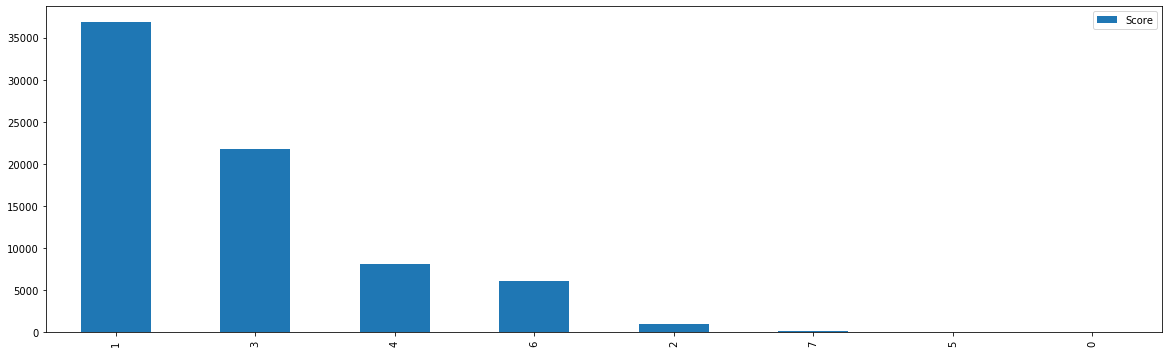

In [6]:
if __name__ == '__main__':
    
    #load data
    data = Data.get_data(file, sample=False, frac=0.1)
    
    #get features
    features_df = Data.get_features()
    
    #get target
    target_df = Data.get_target()
    
    '''Data transformation pipelines'''
    #categrical features to pass down the categorical pipeline 
    categorical_features = ['national_inv', 'in_transit_qty','forecast_3_month']
    
    #numerical features to pass down the numerical pipeline 
    numerical_features = ['national_inv','lead_time','in_transit_qty','forecast_3_month']
    
    #define steps in the categorical pipeline 
    categorical_pipeline = Pipeline( steps = [ ('cat_selector', FeatureSelector(categorical_features)),
                                               ('cat_feats_add', CategoricalFeatsAdded()),                                                                                  
                                               ('delete_unused', DelUnusedCols(features_df)),                                         
                                               ('impute_missing_cat', CategoricalImputerTransformer(features_df))                                                                                                                                                                                                    
                                         ])
    
    #define the steps in the numerical pipeline 
    numerical_pipeline = Pipeline( steps = [ ('num_selector', FeatureSelector(numerical_features)),                                                       
                                             ('remove_negative_values', RemoveNegativeValues(features_df)),                                                                               
                                             ('impute_missing', SimpleImputerTransformer(features_df)),                                        
                                             ('cap_outliers', CapOutliers(features_df)),                                        
                                             ('standard_trans', StandardScalerTransformer(features_df))                                                                           
                                       ] )
    
    #combine numerical and categorical piepline into one full big pipeline horizontally using FeatureUnion
    Models.full_pipeline = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),                                                   
                                                     ('numerical_pipeline', numerical_pipeline)])
    
    #disable pandas chained_assignment warning
    pd.options.mode.chained_assignment = None
    
    #fit data to data transformation pipeline
    prepared_features = Models.full_pipeline.fit_transform(features_df)
    
    '''Data Modeling'''
    #set hyperparameters grid
    Models.hyperparameters(logreg=True, svc=False, lda=False, sgd=False,\
                           randforest=False, gradboost=False, gnb=False)
    
    #validate hyperparameters set correctly
    Models.check_hyperparams_settings()
    
    #set models for fitting
    Models.setting_gridsearch(logreg=True, svc=False, lda=False, sgd=False,\
                              randforest=False, gradboost=False, gnb=False)
    
    #fit models that were set manually in GridSearchCV 
    Models.fit_models(n_iter=5, scoring= 'average_precision', n_jobs = -1,\
                      train_features = prepared_features)
    
    '''Model Results'''
    #get best Model
    Models.get_best_models()

    #get best score
    Models.get_best_score()

    #get best model name
    Models.get_best_model_name()

    #get best params
    Models.get_best_models_params()

    Models.print_best_model_params()
    Models.update_wining_hyperparams()
                        
    #save best model
    Models.save_best_model('deployment/backorder_clf_checkpoint.joblib')

    TestModels.print_summary()

    TestModels.get_impactful_feats(chi2,5) 

# 1. Loading Data

In [5]:
data = Data.get_data(file, sample=False, frac=0.1)

(452670, 9) data loaded



In [6]:
#get Features
features_df = Data.get_features()

(452670, 9) features assigned



In [7]:
#get target
target_df = Data.get_target()

(452670,) ...target rows loaded



In [8]:
data.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_3_month,perf_6_month_avg,deck_risk_Yes,neg_inv_balance,went_on_backorder_Yes
0,92.000000,2.000000,0.000000,0.000000,11.000000,0.330000,0,0,0
1,207.000000,8.000000,16.000000,0.000000,31.000000,0.240000,0,0,0
2,0.000000,2.000000,0.000000,3.000000,0.000000,0.040000,1,0,0
3,9.000000,8.000000,2.000000,0.000000,3.000000,0.980000,0,0,0
4,360.000000,8.000000,0.000000,0.000000,22.000000,0.970000,0,0,0


# 2. Transforming Data

In [9]:
#categrical features to pass down the categorical pipeline 
categorical_features = ['national_inv', 'in_transit_qty','forecast_3_month']

In [10]:
#numerical features to pass down the numerical pipeline 
numerical_features = ['national_inv','lead_time','in_transit_qty',
              'forecast_3_month']

In [11]:
#define steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ('cat_selector', FeatureSelector(categorical_features)),
                                                                                                                          
                                           ('cat_feats_add', CategoricalFeatsAdded()),
                                                                                    
                                           ('delete_unused', DelUnusedCols(features_df)),
                                          
                                           ('impute_missing_cat', CategoricalImputerTransformer(features_df))
                                                                                                                                                                                                            
                                         ])

In [12]:
#define the steps in the numerical pipeline 
numerical_pipeline = Pipeline( steps = [ ('num_selector', FeatureSelector(numerical_features)),                                       
                                                                            
                                         ('remove_negative_values', RemoveNegativeValues(features_df)),
                                                                                
                                         ('impute_missing', SimpleImputerTransformer(features_df)),
                                        
                                         ('cap_outliers', CapOutliers(features_df)),
                                        
                                         ('standard_trans', StandardScalerTransformer(features_df))
                                                                           
                                       ] )

In [13]:
#combine numerical and categorical piepline into one full big pipeline horizontally using FeatureUnion
Models.full_pipeline = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline), 
                                                  
                                                 ('numerical_pipeline', numerical_pipeline)])

In [14]:
#disable pandas chained_assignment warning
pd.options.mode.chained_assignment = None

In [15]:
#fit data to data transformation pipeline
prepared_features = Models.full_pipeline.fit_transform(features_df)

# 3. Model Data

## Set Hyperparameter Grids

In [16]:
#set hyperparameters grid
Models.hyperparameters(logreg=True, svc=False, lda=False, sgd=False,\
                       randforest=False, gradboost=False, gnb=False)

Hyperparameter grid is set



In [17]:
#validate hyperparameters set correctly
Models.check_hyperparams_settings()

Validate gridsearch object set correctly...

lr was found in hyperparameters, and it is a grid.
sv was not found in hyperparameters
ld was not found in hyperparameters
sg was not found in hyperparameters
rf was not found in hyperparameters
gb was not found in hyperparameters
nb was not found in hyperparameters


## Set GridSearch

In [18]:
#set models for fitting
Models.setting_gridsearch(logreg=True, svc=False, lda=False, sgd=False,
                          randforest=False, gradboost=False, gnb=False)


GridSearch object set and ready for fitting



In [19]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           9041        4080         241         271        4720        4390
Swap:          2047           0        2047


# 4. Model Fitting

In [20]:
#fit models that were set manually in GridSearchCV 
Models.fit_models(n_iter=5, scoring= 'average_precision', n_jobs = -1,
                  train_features = prepared_features)


Model fitting started...
lr has been fitted,

Model fitting completed.



# 5. Model Results

Best models and scores stored in best_models dict
Best model hyperparameters updated to hyperparameter grid

**************************** Model Results Summary *****************************


Best Model:  lr

Best Score:  0.76

Best 5 impactful features: 
             Feats        Score
1   low_inventory 36864.048474
3    high_forcast 21812.959918
4    national_inv  8113.502571
6  in_transit_qty  6064.798479
2   low_intransit  1034.934496



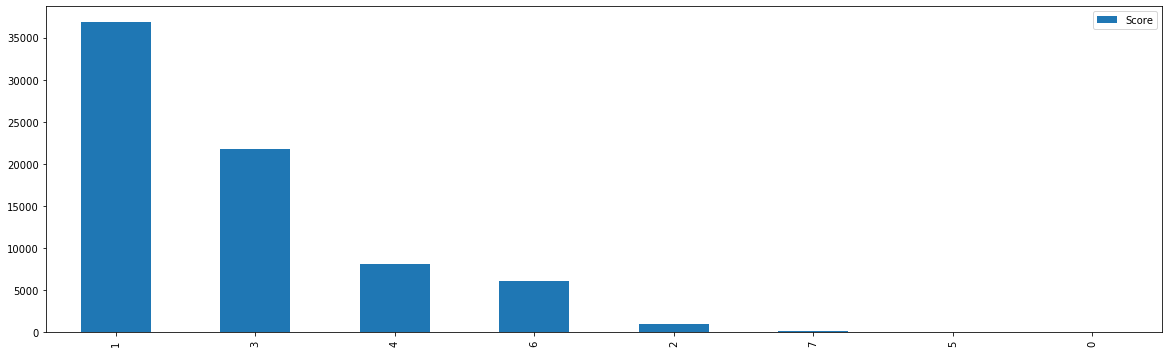

In [21]:
#get best Model
Models.get_best_models()

#get best score
Models.get_best_score()

#get best model name
Models.get_best_model_name()

#get best params
Models.get_best_models_params()

Models.print_best_model_params()
Models.update_wining_hyperparams()
                        
#save best model
Models.save_best_model('deployment/backorder_clf_checkpoint.joblib')

TestModels.print_summary()

TestModels.get_impactful_feats(chi2,5)

# 6. Model Testing

### Load saved model

In [22]:
#TestModels.load_saved_model('backorder_predictor.pkl')
TestModels.load_saved_model('deployment/backorder_clf_checkpoint.joblib')

### Inspect loaded object

In [23]:
#inspect preprocessing parameters
reloaded_full_pipeline = TestModels.clf_checkpoint['preprocessing']

reloaded_full_pipeline

FeatureUnion(transformer_list=[('categorical_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=None)),
                                                ('cat_feats_add',
                                                 CategoricalFeatsAdded(high_forecast=None,
                                                                       low_intransit=None,
                                                                       low_inventory=None,
                                                                       neg_inv_balance=None)),
                                                ('delete_unused',
                                                 DelUnusedCols(features_df=        national_inv  lead_time  in_transit_qty  forecast_3_month  \
0          92.000000   2....
        sales_3_month  perf_6_month_avg  deck_risk_Yes  neg_inv_balance  \
0           11.000000          0.330000     

In [24]:
#inspect reloaded model
clf_model = TestModels.clf_checkpoint['model']

clf_model

LogisticRegression(C=1, random_state=7, solver='saga')

### Transform test features

In [25]:
#transform test_features
test_features_transformed = reloaded_full_pipeline.fit_transform(validation_features)

### Predict test features

In [26]:
#predict transformed test features with our relloaded model
pred_test_results = clf_model.predict(test_features_transformed)

In [27]:
pred_test_results

array([0, 0, 0, ..., 0, 1, 1])

### Append results back to test dataframe

In [28]:
validation_features['predicted_backorder'] = pred_test_results 

In [29]:
validation_features.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,predicted_backorder
0,1604973,4.000000,8.000000,0.000000,0.000000,6.000000,9.000000,1.000000,5.000000,11.000000,...,0.860000,0.880000,0.000000,0,0,0,0,1,0,0
1,1354400,136.000000,8.000000,36.000000,379.000000,727.000000,1057.000000,98.000000,343.000000,674.000000,...,0.960000,0.970000,0.000000,0,0,0,0,1,0,0
2,2236629,26.000000,8.000000,0.000000,0.000000,0.000000,0.000000,4.000000,10.000000,17.000000,...,0.970000,0.980000,0.000000,0,0,0,1,1,0,0
3,1192801,2.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.890000,0.880000,0.000000,0,0,0,0,1,0,0
4,1568451,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,...,0.830000,0.860000,0.000000,0,0,0,0,1,0,0


In [30]:
#drop uneeded columns
drop_cols = range(1,22)
predictions = validation_features.drop(validation_features.columns[drop_cols], axis =1)

print(predictions.shape)

(23649, 2)


In [31]:
predictions.head()

,sku,predicted_backorder
0,1604973,0
1,1354400,0
2,2236629,0
3,1192801,0
4,1568451,0


### Confusion Matrix

In [32]:
#get y_pred, y_test
y_pred = predictions['predicted_backorder']
y_test = validation_target

print(y_pred.shape, y_test.shape)

(23649,) (23649, 1)


In [33]:
#get the confusion matrix
cf_matrix = confusion_matrix(y_pred, y_test)
print(cf_matrix)

[[14252  3335]
 [ 1514  4548]]


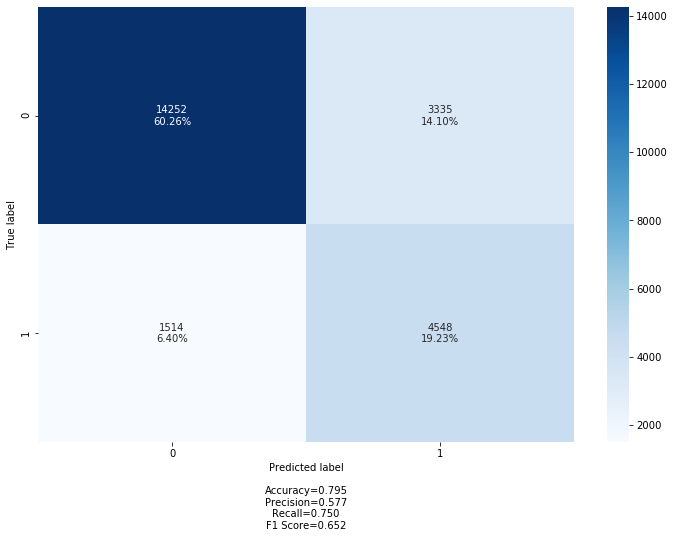

In [34]:
#visualize confusion matrix
make_confusion_matrix.make_confusion_matrix(cf_matrix, figsize = (12,8))

### Save predictions to csv

In [66]:
#write to csv without compression
predictions.to_csv('backorder.csv', index=False)

<h1><center> *END* </center></h1>
<h1><center>***Thank you!***</center></h1>

In [35]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           9041        4035         229         262        4776        4444
Swap:          2047           0        2047
